In [3]:
%matplotlib inline
%config Completer.use_jedi = False

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

In [4]:
train_data = pd.read_excel("../../data/unzipped/Train.xlsx", skiprows=range(1,2), index_col=0, sheet_name=0)

In [5]:
train_data.head()

,"Диффузный индекс цен на выпускаемую продукцию, ожидаемые изменения","Диффузный индекс цен на покупаемую продукцию, ожидаемые изменения","Диффузный индекс заработной платы, ожидаемые изменения","Диффузный индекс занятости, ожидаемые изменения","Диффузный индекс выпуска, ожидаемые изменения","Диффузный индекс закупок оборудования, ожидаемые изменения","Диффузный индекс финансового состояния, ожидаемые изменения","Диффузный индекс портфеля заказов, ожидаемые изменения","Диффузный индекс задолженности банкам, ожидаемые изменения","Производство скота и птицы, тыс.тонн",...,"Среднемесячная пенсия, руб.",Реальная пенсия,MIACR,"Ставка по краткосрочным кредитам, население","Ставка по долгосрочным кредитам, население","Ставка по краткосрочным кредитам, фирмы","Ставка по долгосрочным кредитам, фирмы","Краткосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб","Долгосрочные кредиты и прочие средства нефинансовым организациям, млрд.руб","Цена Urals, долл/бар"
2003m01,74,93,61,40,44,28,47,44,22,6.269096,...,7.288791,0.000000,6.331,21.5,18.9,14.5,17.3,6.993658,6.290272,3.383413
2003m02,78,95,66,37,49,30,53,56,18,6.320768,...,7.313953,0.008960,2.514,22.2,17.8,14.1,19.6,7.019476,6.298398,3.420624
2003m03,84,98,72,45,56,29,51,61,25,6.361302,...,7.314153,-0.001091,2.625,18.3,19.9,13.3,16.4,7.031299,6.325613,3.363693
2003m04,83,95,70,40,66,38,59,69,23,6.269096,...,7.382809,0.057178,1.888,20.0,21.3,13.4,14.9,7.048821,6.343001,3.130242
2003m05,79,94,76,43,66,33,63,68,23,6.177944,...,7.382809,0.049146,1.308,23.1,21.5,12.5,15.0,7.076400,6.371099,3.210488


In [262]:
from scipy.stats import norm
from sklearn.metrics import r2_score, mean_squared_error

def p_val(x):
    return 2 * min(norm.cdf(-x), norm.cdf(x))

def z_test(res1, res2):
    res2 = np.array(res2)
    res1 = np.array(res1)
    delta = res1 - res2
    mu_z = np.mean(delta)
    sigma = np.std(delta)
    z = mu_z / sigma * T ** 0.5
    p = p_val(z)
    win_rate = np.mean(res1 >= res2) 
    return {"p_value":p, "mu": mu_z, "sigma": sigma, "win_rate": win_rate}

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.stattools import adfuller

In [8]:
def remove_nan_prefix(X):
    X = np.array(X, dtype=float)
    last_nan = np.max(list(np.where(np.isnan(X))[0]) + [-1])
    X = X[last_nan + 1:]
    return X

In [9]:
adfuller_vals = []
for i in range(train_data.shape[1]):
    X = train_data.values[:, i]
    X = remove_nan_prefix(X)
    decompose_result = seasonal_decompose(X, model="additive", period=12)

    trend = decompose_result.trend
    seasonal = decompose_result.seasonal
    residual = decompose_result.resid

    diff = X - seasonal
    diff = (diff - np.mean(diff)) / np.std(diff)
    result = adfuller(diff)
    adfuller_vals.append(result[1])

(array([5., 2., 2., 4., 2., 2., 4., 3., 1., 0., 1., 1., 3., 3., 1., 3., 4.,
        3., 1., 1., 2., 1., 0., 1., 2., 4., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 3.]),
 array([0.00127187, 0.02122641, 0.04118095, 0.06113549, 0.08109003,
        0.10104457, 0.12099911, 0.14095365, 0.16090819, 0.18086273,
        0.20081727, 0.22077181, 0.24072635, 0.26068089, 0.28063543,
        0.30058997, 0.32054451, 0.34049905, 0.36045359, 0.38040813,
        0.40036267, 0.42031721, 0.44027175, 0.4602263 , 0.48018084,
        0.50013538, 0.52008992, 0.54004446, 0.559999  , 0.57995354,
        0.59990808, 0.61986262, 0.63981716, 0.6597717 , 0.67972624,
        0.69968078, 0.71963532, 0.73958986, 0.7595444 , 0.77949894,
        0.79945348, 0.81940802, 0.83936256, 0.8593171 , 0.87927164,
        0.89922618, 0.91918072, 0.93913526, 0.9590898 , 0.97904434,
        0.99899888]),
 <BarContainer object of 50 artists>)

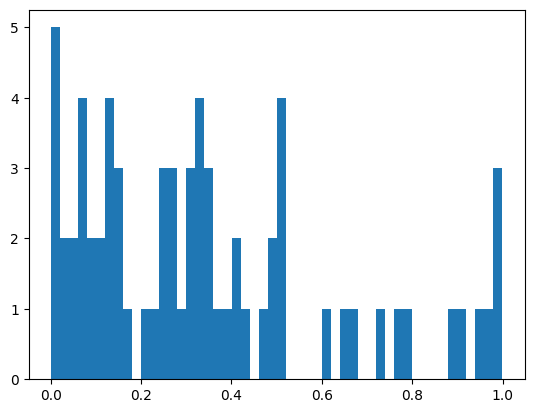

In [10]:
plt.hist(adfuller_vals, bins=50)

In [228]:
def total(wmsfes):
    scores = 0
    alpha = 12
    scores = []
    for m in wmsfes:
        score = (1.8 - 1.6 / (1 + np.exp(-alpha * m)))
        scores.append(score)
    return np.sum(scores) / len(wmsfes), scores


class Task:
    def __init__(self, history, orig, pred, period=12):
        assert period in [4,12]
        self.history = history
        self.orig = orig
        self.pred = pred
        self.period = period


def wmsfe(tasks):
    hm = np.array([len(t.orig) for t in tasks])
    km = np.sum(hm)
    scores = []
    for t in tasks:
        assert t is not None
        assert t.orig.shape == t.pred.shape
        disp = np.var(t.history[t.period:] - t.history[:-t.period])
        disp = np.nan_to_num(disp) + 1e-9
        score = np.sum((t.orig - t.pred) ** 2 / (np.arange(len(t.pred)) + 1)) / disp
        scores.append(score)
    return np.sum(scores) / km, scores / hm

class TaskSet:
    def __init__(self):
        self.groups = []
        
    def buildFromTasks(self, tasks2d):
        for g in tasks2d:
            self.addGroup()
            for t in g:
                self.addTask(t)
        return self

    def addTask(self, task):
        self.groups[-1].append(task)

    def addGroup(self):
        self.groups.append([])

    def calcScore(self):
        losses = []
        for g in self.groups:
            loss, _ = wmsfe(g)
            losses.append(loss)
        return total(losses)
    

def leaderboard(tasks2d):
    return TaskSet().buildFromTasks(tasks2d).calcScore()

In [229]:
window = None

In [230]:
class Normalizer:
    def __init__(self, period):
        self.period = period
        self.try_fallback = False
    
    def transform(self, X):
        X = remove_nan_prefix(X)
        l = X.shape[0]
        if l < 2 * self.period:
            assert False
            ft = 0 if l == 0 else X[0]
            X = np.array([float(ft)] * (3 * self.period - l) + list(X))
            self.try_fallback = True
        r = seasonal_decompose(X, model="additive", period=self.period)
        trend = X - r.seasonal
        
        mean = np.mean(trend)
        std = np.std(trend)
        trend_norm = (trend - mean) / (std + 1e-9)
        
        self.seasonal = r.seasonal
        self.mean = mean
        self.std = std
#         self.trend_model = trend_model
        return trend_norm
    def inverse(self, X):
        X *= self.std
        X += self.mean
        seasons = np.tile(self.seasonal, len(X) // len(self.seasonal) + 1)[:len(X)]
        X += seasons
        return X

In [231]:
class BaseModel:
    def fit(self, X, y):
        pass
    def predict(self, X):
        pass
    
class ZeroModel(BaseModel):
    def predict(self,_):
        return [0]

class LastConstModel(BaseModel):
    def predict(self, X):
        return [X[0][-1]]
    
class FirstConstModel(BaseModel):
    def __init__(self):
        self.const = None

    def predict(self, X):
        if self.const is None:
            self.const = X[0][-1]
        return [self.const]
    
class Weighted(BaseModel):
    def __init__(self, weights, base_model):
        self.weights = weights
        self.base_model = base_model
    def fit(self, X, y):
        return self.base_model.fit(X * self.weights, y)
    def predict(self, X):
        return self.base_model.predict(X * self.weights)
    
class Scaled(BaseModel):
    def __init__(self, weight, base_model):
        self.weight = weight
        self.base_model = base_model
    def fit(self, X, y):
        return self.base_model.fit(X, y)
    def predict(self, X):
        return self.base_model.predict(X) * self.weight
    
class PredictWithDelta(BaseModel):
    def __init__(self, base_model):
        self.base_model = base_model
    def predict(self, X):
        y = self.base_model.predict(X)
        return X[:, -1] + y

In [232]:
def add_cumulative_noise(X, weight=1e-2):
    assert len(X.shape) == 2 and isinstance(X, np.ndarray)
    Z = np.random.normal(size=X.shape)
    W = np.tile(np.arange(X.shape[0], 0, -1).reshape(-1,1), X.shape[1]) / X.shape[0] * weight
    Z = np.cumsum(Z, axis=0) * W
    return X * (1 + Z)

In [16]:
withNoise = add_cumulative_noise(train_data.values)

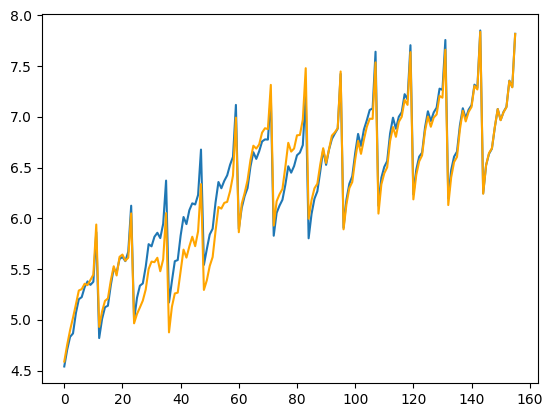

In [17]:
T = 15
plt.plot(train_data.values[:, T])
plt.plot(withNoise[:, T], "orange")

In [414]:
import tqdm

class SearchSequenceIndex:
    def __init__(self, window, period, offset):
        self.window = window
        self.period = period
        self.offset = offset
        
    def get_train_part_and_full(self, X, remove_prefix=0):
        train_gap = self.offset + self.period + self.window
        X = X[remove_prefix:]
        T = X[:-train_gap]
        return T, X
    
    def build(self, X):
        assert len(X.shape) == 2
        self.X_normed = []

        for i in np.arange(X.shape[1]):
            x = X[:, i]
            x = Normalizer(self.period).transform(x)
            for j in range(len(x) - self.window - 1):
                sample = x[j:j + self.window + 1]
                self.X_normed.append(sample)
        self.X_normed = np.array(self.X_normed)
    
    def fit(self, base_model):
        self.base_model = base_model
        X_train = np.array([x[:-1] for x in self.X_normed])
        y_train = np.array([x[-1] - x[-2] for x in self.X_normed])
        self.base_model.fit(X_train, y_train)
        self.base_model = PredictWithDelta(self.base_model)
        
    def predict_for_seq(self, seq, steps):
        assert len(seq.shape) == 1, seq.shape[0] >= 2 * self.window
        normalizer = Normalizer(self.period)
        seq = normalizer.transform(seq)
        for i in np.arange(steps):
            subSeq = seq[-self.window:]
            origSubSeq = subSeq
            x = subSeq.reshape(1,-1)
            if normalizer.try_fallback:
                y = PredictWithDelta(ZeroModel()).predict(x)[0]
            else:
                y = self.base_model.predict(x)[0]
            subSeq = list(subSeq) + [y]
            assert np.mean((subSeq[:-1] - origSubSeq) ** 2) < 1e-6, (subSeq, origSubSeq)
            seq = np.append(seq, subSeq[-1])
        seq = normalizer.inverse(seq)
        return seq

    def measure_on_all_train_data(self, X, offset):
        mse = 0
        N = len(X)
        tasks = []
        for t in np.arange(N):
            history = remove_nan_prefix(X[t])
            window_data = history[:-offset]
            r = self.predict_for_seq(window_data, offset)
            task = Task(window_data, history[-offset:], r[-offset:])
            tasks.append(task)
        return tasks
    
def index_series(X, window, period, model, step=1, noise_iters=0, noise_weight=1e-2, global_offset=15, sample=1):
    np.random.seed(0)
    assert len(X.shape) == 2 and isinstance(X, np.ndarray)
    xlen = X.shape[0]
    scores = []
    losses = []
    use_noise = True if noise_iters > 0 else False
    noise_iters = max(1, noise_iters)
    for t in range(noise_iters):
        for offset in tqdm.tqdm(np.arange(0, xlen - 2 * (period + window + global_offset) - 1, step), position=0):
            index = SearchSequenceIndex(window, period, global_offset)
            T, F = index.get_train_part_and_full(X, offset)
            if sample < 1:
                T = T[:, np.random.choice(np.arange(T.shape[1]),size=int(T.shape[1] * sample), replace=False)]
            if use_noise:
                T = add_cumulative_noise(T, noise_weight)
            index.build(T)
            index.fit(model())
            res = index.measure_on_all_train_data(np.transpose(F), global_offset)
            mean_loss, _losses = wmsfe(res)
            score, scores = total(_losses)
            scores.extend(scores)
            losses.extend(_losses)
    return np.array(scores), np.array(losses)

In [413]:
np.random.choice([1,2,3,4],size=3, replace=False)

array([4, 3, 2])

In [593]:
zero_measures = index_series(
    train_data.values,
    window=12 * 3,
    period=12,
    model=lambda:ZeroModel(),
    step=6,
    noise_iters=3,
    noise_weight=1e-3,
    sample=0.75
)

knn_measures = index_series(
    train_data.values,
    window=12 * 3,
    period=12,
    model=lambda:Scaled(0.5, KNeighborsRegressor(n_neighbors=50)),
    step=6,
    noise_iters=3,
    noise_weight=1e-3,
    sample=0.75
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


In [568]:
reg = MLPRegressor(hidden_layer_sizes = (windowm, 32, 16, 32, windowm), 
                   activation = 'tanh', 
                   solver = 'adam',
                   batch_size=32,
#                    learning_rate_init = 0.0001, 
#                    max_iter = 20, 
#                    tol = 0.0000001, 
                   verbose = True)

In [569]:
def encoder(reg, data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    encoder1 = 1 / (1 + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    encoder1 = 1 / (1 + np.exp(-encoder1))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)

class AutoencKnnWrapper(BaseModel):
    def __init__(self, enc, knn, err_bound=0):
        self.enc = enc
        self.knn = knn
#         self.err_bound = err_bound
    def fit(self, X, y):
        ids = np.arange(len(X))
        self.enc.fit(X, X)
        X_enc = encoder(self.enc, X)
#         print(X_enc.shape)
        self.knn.fit(X_enc, y)
    def predict(self, X):
#         XT = self.enc.predict(X)
#         diff = np.mean((XT - X) ** 2)
#         if diff > self.err_bound:
#             return np.array([0])
        X_enc = encoder(self.enc, X)
        return self.knn.predict(X_enc)

In [578]:
from sklearn.linear_model import Lasso

In [606]:
enc_measures = index_series(
    train_data.values,
    window=12 * 3,
    period=12,
    model=lambda:Scaled(1.0, AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50))),
    step=6,
    noise_iters=3,
    noise_weight=1e-3,
    sample=0.75
)

  0%|                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Iteration 1, loss = 0.17231139
Iteration 2, loss = 0.08288363
Iteration 3, loss = 0.06149914
Iteration 4, loss = 0.05100374
Iteration 5, loss = 0.04541857
Iteration 6, loss = 0.04180299
Iteration 7, loss = 0.03916913
Iteration 8, loss = 0.03719628
Iteration 9, loss = 0.03550513
Iteration 10, loss = 0.03433021
Iteration 11, loss = 0.03305880
Iteration 12, loss = 0.03202231
Iteration 13, loss = 0.03106933
Iteration 14, loss = 0.03016317
Iteration 15, loss = 0.02934253
Iteration 16, loss = 0.02871523
Iteration 17, loss = 0.02808627
Iteration 18, loss = 0.02757656
Iteration 19, loss = 0.02705498
Iteration 20, loss = 0.02656998
Iteration 21, loss = 0.02615358
Iteration 22, loss = 0.02579040
Iteration 23, loss = 0.02559488
Iteration 24, loss = 0.02521991
Iteration 25, loss = 0.02478189
Iteration 26, loss = 0.02438679
Iteration 27, loss = 0.02427101
Iteration 28, loss = 0.02392041
Iteration 29, loss = 0.02356982
Iteration 30, loss = 0.02329498
Iteration 31, loss = 0.02319468
Iteration 32, los

 20%|██████████████████████████████▊                                                                                                                           | 1/5 [00:06<00:26,  6.59s/it]

Iteration 1, loss = 0.19281405
Iteration 2, loss = 0.08997800
Iteration 3, loss = 0.06818412
Iteration 4, loss = 0.05555301
Iteration 5, loss = 0.04873400
Iteration 6, loss = 0.04423917
Iteration 7, loss = 0.04100392
Iteration 8, loss = 0.03835530
Iteration 9, loss = 0.03648002
Iteration 10, loss = 0.03490528
Iteration 11, loss = 0.03345326
Iteration 12, loss = 0.03235410
Iteration 13, loss = 0.03132121
Iteration 14, loss = 0.03049105
Iteration 15, loss = 0.02965189
Iteration 16, loss = 0.02910337
Iteration 17, loss = 0.02827668
Iteration 18, loss = 0.02773913
Iteration 19, loss = 0.02720766
Iteration 20, loss = 0.02669389
Iteration 21, loss = 0.02611155
Iteration 22, loss = 0.02565995
Iteration 23, loss = 0.02526040
Iteration 24, loss = 0.02479343
Iteration 25, loss = 0.02453589
Iteration 26, loss = 0.02410027
Iteration 27, loss = 0.02394240
Iteration 28, loss = 0.02335085
Iteration 29, loss = 0.02306545
Iteration 30, loss = 0.02270886
Iteration 31, loss = 0.02249530
Iteration 32, los

 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 2/5 [00:12<00:18,  6.22s/it]

Iteration 1, loss = 0.21488536
Iteration 2, loss = 0.09611825
Iteration 3, loss = 0.07051500
Iteration 4, loss = 0.05875238
Iteration 5, loss = 0.05224620
Iteration 6, loss = 0.04762884
Iteration 7, loss = 0.04414202
Iteration 8, loss = 0.04129749
Iteration 9, loss = 0.03934190
Iteration 10, loss = 0.03738755
Iteration 11, loss = 0.03601538
Iteration 12, loss = 0.03483971
Iteration 13, loss = 0.03363907
Iteration 14, loss = 0.03263969
Iteration 15, loss = 0.03162231
Iteration 16, loss = 0.03071069
Iteration 17, loss = 0.02983760
Iteration 18, loss = 0.02908514
Iteration 19, loss = 0.02831166
Iteration 20, loss = 0.02766844
Iteration 21, loss = 0.02712784
Iteration 22, loss = 0.02661330
Iteration 23, loss = 0.02632407
Iteration 24, loss = 0.02582103
Iteration 25, loss = 0.02548964
Iteration 26, loss = 0.02526845
Iteration 27, loss = 0.02482102
Iteration 28, loss = 0.02460126
Iteration 29, loss = 0.02417722
Iteration 30, loss = 0.02392857
Iteration 31, loss = 0.02367780
Iteration 32, los

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3/5 [00:17<00:11,  5.83s/it]

Iteration 1, loss = 0.22921111
Iteration 2, loss = 0.09919835
Iteration 3, loss = 0.06804691
Iteration 4, loss = 0.05503237
Iteration 5, loss = 0.04822801
Iteration 6, loss = 0.04320438
Iteration 7, loss = 0.03962120
Iteration 8, loss = 0.03675187
Iteration 9, loss = 0.03479981
Iteration 10, loss = 0.03305802
Iteration 11, loss = 0.03190774
Iteration 12, loss = 0.03072114
Iteration 13, loss = 0.02974485
Iteration 14, loss = 0.02902334
Iteration 15, loss = 0.02798932
Iteration 16, loss = 0.02727955
Iteration 17, loss = 0.02656411
Iteration 18, loss = 0.02596220
Iteration 19, loss = 0.02545812
Iteration 20, loss = 0.02485483
Iteration 21, loss = 0.02458389
Iteration 22, loss = 0.02398035
Iteration 23, loss = 0.02355332
Iteration 24, loss = 0.02314388
Iteration 25, loss = 0.02273593
Iteration 26, loss = 0.02248750
Iteration 27, loss = 0.02226603
Iteration 28, loss = 0.02191252
Iteration 29, loss = 0.02151024
Iteration 30, loss = 0.02117085
Iteration 31, loss = 0.02097306
Iteration 32, los

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4/5 [00:22<00:05,  5.34s/it]

Iteration 1, loss = 0.29054167
Iteration 2, loss = 0.12025475
Iteration 3, loss = 0.08626525
Iteration 4, loss = 0.06849847
Iteration 5, loss = 0.05818265
Iteration 6, loss = 0.05174371
Iteration 7, loss = 0.04738515
Iteration 8, loss = 0.04353065
Iteration 9, loss = 0.04061155
Iteration 10, loss = 0.03815533
Iteration 11, loss = 0.03622769
Iteration 12, loss = 0.03480118
Iteration 13, loss = 0.03342760
Iteration 14, loss = 0.03234184
Iteration 15, loss = 0.03137038
Iteration 16, loss = 0.03057300
Iteration 17, loss = 0.03004733
Iteration 18, loss = 0.02912927
Iteration 19, loss = 0.02849465
Iteration 20, loss = 0.02797654
Iteration 21, loss = 0.02745429
Iteration 22, loss = 0.02701743
Iteration 23, loss = 0.02647939
Iteration 24, loss = 0.02591264
Iteration 25, loss = 0.02553269
Iteration 26, loss = 0.02507907
Iteration 27, loss = 0.02458980
Iteration 28, loss = 0.02421668
Iteration 29, loss = 0.02386286
Iteration 30, loss = 0.02343201
Iteration 31, loss = 0.02316395
Iteration 32, los

  0%|                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Iteration 1, loss = 0.17915981
Iteration 2, loss = 0.07908921
Iteration 3, loss = 0.05502234
Iteration 4, loss = 0.04671695
Iteration 5, loss = 0.04206683
Iteration 6, loss = 0.03904884
Iteration 7, loss = 0.03664486
Iteration 8, loss = 0.03453206
Iteration 9, loss = 0.03293729
Iteration 10, loss = 0.03149204
Iteration 11, loss = 0.03023337
Iteration 12, loss = 0.02927148
Iteration 13, loss = 0.02837087
Iteration 14, loss = 0.02756899
Iteration 15, loss = 0.02670826
Iteration 16, loss = 0.02611389
Iteration 17, loss = 0.02537833
Iteration 18, loss = 0.02485037
Iteration 19, loss = 0.02438996
Iteration 20, loss = 0.02395335
Iteration 21, loss = 0.02340302
Iteration 22, loss = 0.02311757
Iteration 23, loss = 0.02262914
Iteration 24, loss = 0.02216769
Iteration 25, loss = 0.02185641
Iteration 26, loss = 0.02170849
Iteration 27, loss = 0.02153209
Iteration 28, loss = 0.02107630
Iteration 29, loss = 0.02083637
Iteration 30, loss = 0.02066518
Iteration 31, loss = 0.02047570
Iteration 32, los

 20%|██████████████████████████████▊                                                                                                                           | 1/5 [00:05<00:22,  5.64s/it]

Iteration 1, loss = 0.19994581
Iteration 2, loss = 0.08119586
Iteration 3, loss = 0.06198574
Iteration 4, loss = 0.05289807
Iteration 5, loss = 0.04718109
Iteration 6, loss = 0.04248976
Iteration 7, loss = 0.03885880
Iteration 8, loss = 0.03611542
Iteration 9, loss = 0.03413306
Iteration 10, loss = 0.03270885
Iteration 11, loss = 0.03150295
Iteration 12, loss = 0.03046768
Iteration 13, loss = 0.02954204
Iteration 14, loss = 0.02871775
Iteration 15, loss = 0.02799617
Iteration 16, loss = 0.02746675
Iteration 17, loss = 0.02672274
Iteration 18, loss = 0.02626484
Iteration 19, loss = 0.02567166
Iteration 20, loss = 0.02504132
Iteration 21, loss = 0.02452689
Iteration 22, loss = 0.02424592
Iteration 23, loss = 0.02376501
Iteration 24, loss = 0.02333578
Iteration 25, loss = 0.02292097
Iteration 26, loss = 0.02264217
Iteration 27, loss = 0.02239848
Iteration 28, loss = 0.02209947
Iteration 29, loss = 0.02181369
Iteration 30, loss = 0.02157233
Iteration 31, loss = 0.02113246
Iteration 32, los

 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 2/5 [00:11<00:16,  5.61s/it]

Iteration 1, loss = 0.22011733
Iteration 2, loss = 0.09222978
Iteration 3, loss = 0.06598429
Iteration 4, loss = 0.05526556
Iteration 5, loss = 0.04907852
Iteration 6, loss = 0.04440623
Iteration 7, loss = 0.04057248
Iteration 8, loss = 0.03782052
Iteration 9, loss = 0.03569613
Iteration 10, loss = 0.03399839
Iteration 11, loss = 0.03263019
Iteration 12, loss = 0.03134119
Iteration 13, loss = 0.03049212
Iteration 14, loss = 0.02942738
Iteration 15, loss = 0.02876572
Iteration 16, loss = 0.02804900
Iteration 17, loss = 0.02727866
Iteration 18, loss = 0.02663499
Iteration 19, loss = 0.02599270
Iteration 20, loss = 0.02556701
Iteration 21, loss = 0.02505213
Iteration 22, loss = 0.02451077
Iteration 23, loss = 0.02415052
Iteration 24, loss = 0.02375974
Iteration 25, loss = 0.02336784
Iteration 26, loss = 0.02307071
Iteration 27, loss = 0.02273248
Iteration 28, loss = 0.02244417
Iteration 29, loss = 0.02205680
Iteration 30, loss = 0.02189049
Iteration 31, loss = 0.02162447
Iteration 32, los

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3/5 [00:16<00:10,  5.46s/it]

Iteration 1, loss = 0.24721304
Iteration 2, loss = 0.10043841
Iteration 3, loss = 0.07356576
Iteration 4, loss = 0.06179314
Iteration 5, loss = 0.05512960
Iteration 6, loss = 0.05055097
Iteration 7, loss = 0.04713533
Iteration 8, loss = 0.04435440
Iteration 9, loss = 0.04215180
Iteration 10, loss = 0.04010909
Iteration 11, loss = 0.03856456
Iteration 12, loss = 0.03718723
Iteration 13, loss = 0.03594940
Iteration 14, loss = 0.03495903
Iteration 15, loss = 0.03376874
Iteration 16, loss = 0.03291049
Iteration 17, loss = 0.03204585
Iteration 18, loss = 0.03121564
Iteration 19, loss = 0.03073648
Iteration 20, loss = 0.02991881
Iteration 21, loss = 0.02928563
Iteration 22, loss = 0.02874417
Iteration 23, loss = 0.02818995
Iteration 24, loss = 0.02781338
Iteration 25, loss = 0.02711982
Iteration 26, loss = 0.02688282
Iteration 27, loss = 0.02636901
Iteration 28, loss = 0.02611249
Iteration 29, loss = 0.02566509
Iteration 30, loss = 0.02527234
Iteration 31, loss = 0.02501444
Iteration 32, los

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4/5 [00:21<00:05,  5.42s/it]

Iteration 1, loss = 0.25941031
Iteration 2, loss = 0.11387228
Iteration 3, loss = 0.08141314
Iteration 4, loss = 0.06586507
Iteration 5, loss = 0.05822308
Iteration 6, loss = 0.05371764
Iteration 7, loss = 0.05037101
Iteration 8, loss = 0.04771748
Iteration 9, loss = 0.04555475
Iteration 10, loss = 0.04334571
Iteration 11, loss = 0.04148181
Iteration 12, loss = 0.03972889
Iteration 13, loss = 0.03835264
Iteration 14, loss = 0.03697332
Iteration 15, loss = 0.03576368
Iteration 16, loss = 0.03491346
Iteration 17, loss = 0.03370839
Iteration 18, loss = 0.03292615
Iteration 19, loss = 0.03211462
Iteration 20, loss = 0.03139024
Iteration 21, loss = 0.03063691
Iteration 22, loss = 0.03008467
Iteration 23, loss = 0.02933784
Iteration 24, loss = 0.02880383
Iteration 25, loss = 0.02836888
Iteration 26, loss = 0.02780420
Iteration 27, loss = 0.02731513
Iteration 28, loss = 0.02695185
Iteration 29, loss = 0.02641333
Iteration 30, loss = 0.02606476
Iteration 31, loss = 0.02560020
Iteration 32, los

  0%|                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Iteration 1, loss = 0.18359424
Iteration 2, loss = 0.07685541
Iteration 3, loss = 0.05809274
Iteration 4, loss = 0.04837440
Iteration 5, loss = 0.04296994
Iteration 6, loss = 0.03907537
Iteration 7, loss = 0.03627663
Iteration 8, loss = 0.03396509
Iteration 9, loss = 0.03210722
Iteration 10, loss = 0.03084006
Iteration 11, loss = 0.02968153
Iteration 12, loss = 0.02880621
Iteration 13, loss = 0.02804544
Iteration 14, loss = 0.02734849
Iteration 15, loss = 0.02667579
Iteration 16, loss = 0.02613725
Iteration 17, loss = 0.02557534
Iteration 18, loss = 0.02514479
Iteration 19, loss = 0.02467814
Iteration 20, loss = 0.02426020
Iteration 21, loss = 0.02373319
Iteration 22, loss = 0.02335989
Iteration 23, loss = 0.02297041
Iteration 24, loss = 0.02251104
Iteration 25, loss = 0.02207639
Iteration 26, loss = 0.02165790
Iteration 27, loss = 0.02140066
Iteration 28, loss = 0.02115931
Iteration 29, loss = 0.02097341
Iteration 30, loss = 0.02068225
Iteration 31, loss = 0.02041985
Iteration 32, los

 20%|██████████████████████████████▊                                                                                                                           | 1/5 [00:05<00:20,  5.12s/it]

Iteration 1, loss = 0.22084712
Iteration 2, loss = 0.08170748
Iteration 3, loss = 0.06007010
Iteration 4, loss = 0.04839805
Iteration 5, loss = 0.04181562
Iteration 6, loss = 0.03785613
Iteration 7, loss = 0.03506367
Iteration 8, loss = 0.03265752
Iteration 9, loss = 0.03100365
Iteration 10, loss = 0.02949689
Iteration 11, loss = 0.02840162
Iteration 12, loss = 0.02729563
Iteration 13, loss = 0.02620469
Iteration 14, loss = 0.02564053
Iteration 15, loss = 0.02505350
Iteration 16, loss = 0.02420343
Iteration 17, loss = 0.02350540
Iteration 18, loss = 0.02294075
Iteration 19, loss = 0.02252409
Iteration 20, loss = 0.02200571
Iteration 21, loss = 0.02167995
Iteration 22, loss = 0.02131672
Iteration 23, loss = 0.02097547
Iteration 24, loss = 0.02054387
Iteration 25, loss = 0.02032690
Iteration 26, loss = 0.01992967
Iteration 27, loss = 0.01989283
Iteration 28, loss = 0.01942692
Iteration 29, loss = 0.01905425
Iteration 30, loss = 0.01883625
Iteration 31, loss = 0.01858553
Iteration 32, los

 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 2/5 [00:10<00:15,  5.29s/it]

Iteration 1, loss = 0.22153598
Iteration 2, loss = 0.08374079
Iteration 3, loss = 0.05804548
Iteration 4, loss = 0.04699388
Iteration 5, loss = 0.04023279
Iteration 6, loss = 0.03605691
Iteration 7, loss = 0.03324592
Iteration 8, loss = 0.03134147
Iteration 9, loss = 0.02965208
Iteration 10, loss = 0.02848073
Iteration 11, loss = 0.02750120
Iteration 12, loss = 0.02680018
Iteration 13, loss = 0.02604950
Iteration 14, loss = 0.02539113
Iteration 15, loss = 0.02491741
Iteration 16, loss = 0.02418262
Iteration 17, loss = 0.02361123
Iteration 18, loss = 0.02305525
Iteration 19, loss = 0.02274681
Iteration 20, loss = 0.02202410
Iteration 21, loss = 0.02160141
Iteration 22, loss = 0.02112337
Iteration 23, loss = 0.02063680
Iteration 24, loss = 0.02029891
Iteration 25, loss = 0.01982087
Iteration 26, loss = 0.01959261
Iteration 27, loss = 0.01934102
Iteration 28, loss = 0.01901038
Iteration 29, loss = 0.01872131
Iteration 30, loss = 0.01861189
Iteration 31, loss = 0.01839147
Iteration 32, los

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3/5 [00:16<00:11,  5.78s/it]

Iteration 1, loss = 0.23346398
Iteration 2, loss = 0.10282189
Iteration 3, loss = 0.07584789
Iteration 4, loss = 0.06449273
Iteration 5, loss = 0.05795407
Iteration 6, loss = 0.05307055
Iteration 7, loss = 0.04926326
Iteration 8, loss = 0.04648654
Iteration 9, loss = 0.04394339
Iteration 10, loss = 0.04218372
Iteration 11, loss = 0.04052135
Iteration 12, loss = 0.03896159
Iteration 13, loss = 0.03802698
Iteration 14, loss = 0.03705023
Iteration 15, loss = 0.03603457
Iteration 16, loss = 0.03517423
Iteration 17, loss = 0.03428490
Iteration 18, loss = 0.03349329
Iteration 19, loss = 0.03268712
Iteration 20, loss = 0.03202706
Iteration 21, loss = 0.03129437
Iteration 22, loss = 0.03061615
Iteration 23, loss = 0.03006912
Iteration 24, loss = 0.02946501
Iteration 25, loss = 0.02884642
Iteration 26, loss = 0.02844944
Iteration 27, loss = 0.02793803
Iteration 28, loss = 0.02756423
Iteration 29, loss = 0.02710669
Iteration 30, loss = 0.02662618
Iteration 31, loss = 0.02639785
Iteration 32, los

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4/5 [00:22<00:05,  5.69s/it]

Iteration 1, loss = 0.28706884
Iteration 2, loss = 0.11470892
Iteration 3, loss = 0.08148420
Iteration 4, loss = 0.06765659
Iteration 5, loss = 0.06007952
Iteration 6, loss = 0.05464139
Iteration 7, loss = 0.05037714
Iteration 8, loss = 0.04729987
Iteration 9, loss = 0.04455525
Iteration 10, loss = 0.04258145
Iteration 11, loss = 0.04087619
Iteration 12, loss = 0.03950157
Iteration 13, loss = 0.03832303
Iteration 14, loss = 0.03732114
Iteration 15, loss = 0.03637593
Iteration 16, loss = 0.03549283
Iteration 17, loss = 0.03466590
Iteration 18, loss = 0.03390004
Iteration 19, loss = 0.03312506
Iteration 20, loss = 0.03239690
Iteration 21, loss = 0.03157069
Iteration 22, loss = 0.03085733
Iteration 23, loss = 0.03012490
Iteration 24, loss = 0.02937540
Iteration 25, loss = 0.02875330
Iteration 26, loss = 0.02822294
Iteration 27, loss = 0.02756501
Iteration 28, loss = 0.02729231
Iteration 29, loss = 0.02661284
Iteration 30, loss = 0.02614959
Iteration 31, loss = 0.02565538
Iteration 32, los

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.44s/it]


In [594]:
np.mean(knn_measures[0]), np.mean(zero_measures[0]), z_test(knn_measures[0], zero_measures[0])

(0.3621521373631788,
 0.34097475092624124,
 {'p_value': 0.1682653919042325,
  'mu': 0.021177386436937548,
  'sigma': 0.09841888997030773,
  'win_rate': 0.6521739130434783})

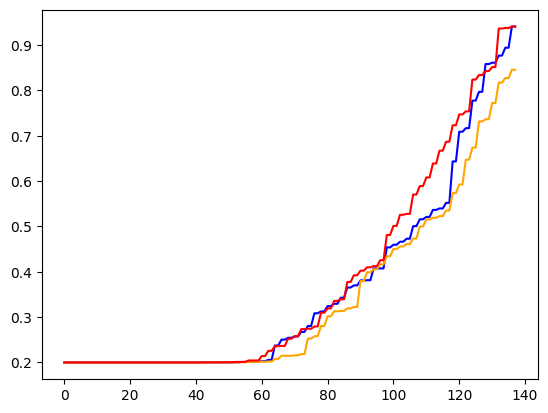

In [607]:
plt.plot(np.sort(knn_measures[0]), 'blue')
plt.plot(np.sort(zero_measures[0]), 'orange')
plt.plot(np.sort(enc_measures[0]), 'red')

In [608]:
np.mean(knn_measures[1]), np.mean(zero_measures[1]), z_test(knn_measures[1], zero_measures[1])

(1.624751242230631,
 1.6973818018010343,
 {'p_value': 0.15601606042598445,
  'mu': -0.07263055957040336,
  'sigma': 0.3278323274794252,
  'win_rate': 0.38067632850241545})

In [609]:
np.mean(enc_measures[0]), np.mean(zero_measures[0]), z_test(enc_measures[0], zero_measures[0])

(0.3793838449769264,
 0.34097475092624124,
 {'p_value': 0.12108405474827573,
  'mu': 0.038409094050685086,
  'sigma': 0.15864529915792094,
  'win_rate': 0.5217391304347826})

In [610]:
np.mean(enc_measures[1]), np.mean(zero_measures[1]), z_test(enc_measures[1], zero_measures[1])

(1.598524526316335,
 1.6973818018010343,
 {'p_value': 0.2950455827771611,
  'mu': -0.09885727548469926,
  'sigma': 0.6045125505808853,
  'win_rate': 0.4975845410628019})

In [611]:
np.mean(enc_measures[1]), np.mean(knn_measures[1]), z_test(enc_measures[1], knn_measures[1])

(1.598524526316335,
 1.624751242230631,
 {'p_value': 0.5990975967436475,
  'mu': -0.02622671591429589,
  'sigma': 0.31944711661218467,
  'win_rate': 0.578743961352657})

In [612]:
np.mean(enc_measures[0]), np.mean(knn_measures[0]), z_test(enc_measures[0], knn_measures[0])

(0.3793838449769264,
 0.3621521373631788,
 {'p_value': 0.42105169453149205,
  'mu': 0.01723170761374753,
  'sigma': 0.1371327845366476,
  'win_rate': 0.4492753623188406})

In [ ]:
# reg = MLPRegressor(hidden_layer_sizes = (windowm, 16, 8, 16, windowm), 
#                    activation = 'tanh', 
#                    solver = 'adam',
# #                    learning_rate_init = 0.0001, 
# #                    max_iter = 20, 
# #                    tol = 0.0000001, 
#                    verbose = True)

In [2645]:
train_data.values.shape

(156, 69)

knn:  1.5445594509414997 (0.37191490318074705, [0.2674416612166981, 0.29322322485038255, 0.41395979153041784, 0.40578971850697076, 0.20106105902609084, 0.2582392774903457, 0.20046341391457934, 0.20000202626849095, 0.2187227492335535, 0.19999999999999996, 0.19999999999999996, 0.20000000000000306, 0.37662327746227686, 0.4065722591008816, 0.2662174474308223, 0.19999999999999996, 0.19999999999999996, 0.19999999999999996, 0.19999999999999996, 0.3098394254135928, 0.2002307989109331, 0.3657653386989981, 0.20477182166466323, 0.2000000000011648, 0.20000000000086748, 0.19999999999999996, 0.2000098598797544, 0.20000000644424354, 0.20024037926109073, 0.20000000005216623, 0.20000293186555207, 0.20000021355677644, 0.2915202616692658, 0.28575009284869557, 0.2003206908037336, 0.20000639524834307, 0.20000635671766864, 0.20090779378570733, 0.19999999999999996, 0.5756888979582802, 0.6620031256439582, 0.9572522627760223, 0.6790192815439942, 0.42873913734047586, 0.913759659282092, 0.5286361417952872, 0.600

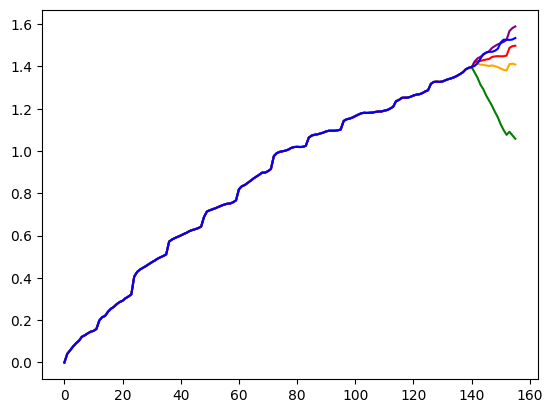

In [625]:
T = 39

offset = 15
index = SearchSequenceIndex(window=12 * 3, period=12, offset=offset)

pref, full = index.get_train_part_and_full(train_data.values)
index.build(pref)

orig = train_data.values[:, T]
window_data = orig[:-offset]

index.fit(Scaled(0.5, KNeighborsRegressor(n_neighbors=50)))
r1 = index.predict_for_seq(window_data, offset)
knn_res = index.measure_on_all_train_data(full.T, offset=offset)
knn_scores = wmsfe(knn_res)
print('knn: ', knn_scores[0], leaderboard([[x] for x in knn_res]))

index.fit(LinearRegression())
r2 = index.predict_for_seq(window_data, offset)

index.fit(ZeroModel())
r3 = index.predict_for_seq(window_data, offset)
zero_res = index.measure_on_all_train_data(full.T, offset=offset)
zero_scores = wmsfe(zero_res)

print('zero: ', zero_scores[0], leaderboard([[x] for x in zero_res]))

print('log z-test: ', log_z_test(knn_scores[1], zero_scores[1]))

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
r4 = index.predict_for_seq(window_data, offset)
res = index.measure_on_all_train_data(full.T, offset=offset)
scores = wmsfe(res)

plt.plot(r1, 'red')
plt.plot(r2, 'green')
plt.plot(r3, 'orange')
plt.plot(r4, 'purple')
plt.plot(train_data.values[:, T], 'blue')
plt.show()

In [97]:
test_data = []
for i in range(14):
    test_data.append(pd.read_excel("../../data/unzipped/Test_example{}.xlsx".format(i+1), index_col=0))

In [626]:
X = []
for i in range(14):
    for f in np.arange(test_data[i].shape[1]):
        seq = test_data[i].values[:, f]
        seq = seq[np.where(seq != "Forecast")]
        if len(seq) >= 12 * 5:
            X.append(seq)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [627]:
len([len(x) for x in X if len(x) >= 12 * 5]), len(X)

(58, 58)

In [630]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(train_data.values)

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
knn_res = index.measure_on_all_train_data(X, offset=15)
knn_scores = wmsfe(knn_res)
print('knn: ', np.mean(knn_scores[0]))#, leaderboard([[x] for x in knn_res]))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(X, offset=15)
zero_scores = wmsfe(zero_res)

print('zero: ', np.mean(zero_scores[0]))#, leaderboard([[x] for x in zero_res]))

print('z-test: ', z_test(knn_scores[1], zero_scores[1]))

Iteration 1, loss = 0.11553871
Iteration 2, loss = 0.05028768
Iteration 3, loss = 0.03881310
Iteration 4, loss = 0.03312687
Iteration 5, loss = 0.03001217
Iteration 6, loss = 0.02812924
Iteration 7, loss = 0.02679238
Iteration 8, loss = 0.02567155
Iteration 9, loss = 0.02480812
Iteration 10, loss = 0.02397167
Iteration 11, loss = 0.02320318
Iteration 12, loss = 0.02247370
Iteration 13, loss = 0.02204387
Iteration 14, loss = 0.02148675
Iteration 15, loss = 0.02102921
Iteration 16, loss = 0.02058375
Iteration 17, loss = 0.02019548
Iteration 18, loss = 0.01994778
Iteration 19, loss = 0.01975606
Iteration 20, loss = 0.01955177
Iteration 21, loss = 0.01935262
Iteration 22, loss = 0.01921650
Iteration 23, loss = 0.01911270
Iteration 24, loss = 0.01900069
Iteration 25, loss = 0.01890512
Iteration 26, loss = 0.01880410
Iteration 27, loss = 0.01867410
Iteration 28, loss = 0.01865139
Iteration 29, loss = 0.01857854
Iteration 30, loss = 0.01856639
Iteration 31, loss = 0.01843961
Iteration 32, los

In [653]:
quartal_data = pd.read_excel("../../data/unzipped/Train.xlsx", skiprows=range(1,2), index_col=0,sheet_name=1)

In [654]:
quartal_data.head()

,"ВВП, млрд",Реальный ВВП,"ВВП A, млрд.руб.","ВВП B, млрд.руб.","ВВП C, млрд.руб.","ВВП D, млрд.руб.","ВВП E, млрд.руб.","ВВП F, млрд.руб.","ВВП G, млрд.руб.","ВВП H, млрд.руб.",...,Реальный ВВП K,Реальный ВВП L,Реальный ВВП M,Реальный ВВП N,Реальный ВВП O,Реальные налоги на продукты,Реальные субсидии на продукты,"Инвестиции, собственные средства, млрд.руб.","Инвестиции, привлеченные средства, млрд.руб.","Инвестиции, бюджетные средства, млрд.руб."
2003m03,8.041233,0.000000,4.273602,2.633625,5.134760,5.926435,4.786542,4.884884,6.374866,2.944192,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.872905,4.911183,3.832980
2003m06,8.115856,0.067384,4.520113,2.511972,5.133081,6.073957,4.461686,5.208554,6.393228,3.151690,...,0.032777,0.005775,-0.017488,0.016888,0.049110,0.047356,0.032027,5.249127,5.455748,4.391977
2003m09,8.255223,0.119733,5.690798,2.816459,5.328411,6.158050,4.357089,5.476453,6.477670,3.245579,...,0.042272,0.060595,0.019040,0.037533,0.096204,0.063358,0.211227,5.367843,5.540086,4.513055
2003m12,8.265189,0.171204,4.979387,2.691399,5.296727,6.212625,4.766878,5.468805,6.588304,3.254391,...,0.130738,0.090004,0.043583,0.019568,0.228176,0.100861,0.024644,5.668501,5.927459,4.940213
2004m03,8.250766,0.069902,4.356881,2.822974,5.633453,6.213559,5.063559,5.077852,6.491535,3.362732,...,-0.087127,0.037359,-0.001314,0.011056,0.069604,0.096598,-0.046582,5.017942,5.226284,3.910021


In [656]:
quartal_data.values.shape

(52, 39)

In [659]:
windowq = 4  * 3

In [660]:
index = SearchSequenceIndex(window=windowq, period=4, offset=5)
index.build(quartal_data.values)

T = 30
offset = 5
orig = quartal_data.values[:, T]
window_data = orig[:-offset]

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
r1 = index.predict_for_seq(window_data, offset)
knn_res = index.measure_on_all_train_data(quartal_data.values, offset=5)

Iteration 1, loss = 0.17763052
Iteration 2, loss = 0.05730871
Iteration 3, loss = 0.03987083
Iteration 4, loss = 0.03122359
Iteration 5, loss = 0.02606020
Iteration 6, loss = 0.02236719
Iteration 7, loss = 0.01934756
Iteration 8, loss = 0.01675167
Iteration 9, loss = 0.01447772
Iteration 10, loss = 0.01267143
Iteration 11, loss = 0.01145221
Iteration 12, loss = 0.01032097
Iteration 13, loss = 0.00934638
Iteration 14, loss = 0.00848448
Iteration 15, loss = 0.00790324
Iteration 16, loss = 0.00747203
Iteration 17, loss = 0.00682574
Iteration 18, loss = 0.00651482
Iteration 19, loss = 0.00613609
Iteration 20, loss = 0.00578451
Iteration 21, loss = 0.00544661
Iteration 22, loss = 0.00528916
Iteration 23, loss = 0.00488579
Iteration 24, loss = 0.00463711
Iteration 25, loss = 0.00460749
Iteration 26, loss = 0.00436320
Iteration 27, loss = 0.00423243
Iteration 28, loss = 0.00400708
Iteration 29, loss = 0.00391018
Iteration 30, loss = 0.00373296
Iteration 31, loss = 0.00359876
Iteration 32, los

In [661]:
zero_measures = index_series(
    quartal_data.values,
    window=windowq,
    period=4,
    model=lambda:ZeroModel(),
    step=1,
    noise_iters=0,
    global_offset=5
)

knn_measures = index_series(
    quartal_data.values,
    window=windowq,
    period=4,
    model=lambda:AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)),
    step=1,
    noise_iters=0,
    global_offset=5
)

  0%|                                                                                                                                                                  | 0/9 [00:00<?, ?it/s]

Iteration 1, loss = 0.28816403
Iteration 2, loss = 0.08787475
Iteration 3, loss = 0.05661842
Iteration 4, loss = 0.04721693
Iteration 5, loss = 0.04186564
Iteration 6, loss = 0.03750921
Iteration 7, loss = 0.03378626
Iteration 8, loss = 0.03038337
Iteration 9, loss = 0.02731187
Iteration 10, loss = 0.02483532
Iteration 11, loss = 0.02261112
Iteration 12, loss = 0.02081445
Iteration 13, loss = 0.01947926
Iteration 14, loss = 0.01820696
Iteration 15, loss = 0.01707598
Iteration 16, loss = 0.01604511
Iteration 17, loss = 0.01503611
Iteration 18, loss = 0.01421167
Iteration 19, loss = 0.01340898
Iteration 20, loss = 0.01258717
Iteration 21, loss = 0.01198934
Iteration 22, loss = 0.01132473
Iteration 23, loss = 0.01077560
Iteration 24, loss = 0.01028675
Iteration 25, loss = 0.00978280
Iteration 26, loss = 0.00938569
Iteration 27, loss = 0.00892519
Iteration 28, loss = 0.00858456
Iteration 29, loss = 0.00819174
Iteration 30, loss = 0.00782174
Iteration 31, loss = 0.00752171
Iteration 32, los

 11%|█████████████████                                                                                                                                         | 1/9 [00:01<00:10,  1.29s/it]

Iteration 1, loss = 0.25887920
Iteration 2, loss = 0.09297392
Iteration 3, loss = 0.06245215
Iteration 4, loss = 0.04994402
Iteration 5, loss = 0.04250532
Iteration 6, loss = 0.03715250
Iteration 7, loss = 0.03330203
Iteration 8, loss = 0.02994761
Iteration 9, loss = 0.02732433
Iteration 10, loss = 0.02519857
Iteration 11, loss = 0.02331127
Iteration 12, loss = 0.02178847
Iteration 13, loss = 0.02051872
Iteration 14, loss = 0.01915504
Iteration 15, loss = 0.01816682
Iteration 16, loss = 0.01707619
Iteration 17, loss = 0.01626848
Iteration 18, loss = 0.01571867
Iteration 19, loss = 0.01503792
Iteration 20, loss = 0.01456770
Iteration 21, loss = 0.01404837
Iteration 22, loss = 0.01361332
Iteration 23, loss = 0.01316694
Iteration 24, loss = 0.01277158
Iteration 25, loss = 0.01246159
Iteration 26, loss = 0.01186531
Iteration 27, loss = 0.01153699
Iteration 28, loss = 0.01092715
Iteration 29, loss = 0.01055679
Iteration 30, loss = 0.01009668
Iteration 31, loss = 0.00965662
Iteration 32, los

 22%|██████████████████████████████████▏                                                                                                                       | 2/9 [00:02<00:08,  1.16s/it]

Iteration 1, loss = 0.22579698
Iteration 2, loss = 0.08897440
Iteration 3, loss = 0.06089010
Iteration 4, loss = 0.05012751
Iteration 5, loss = 0.04382745
Iteration 6, loss = 0.03881472
Iteration 7, loss = 0.03428461
Iteration 8, loss = 0.03039171
Iteration 9, loss = 0.02706663
Iteration 10, loss = 0.02434791
Iteration 11, loss = 0.02206375
Iteration 12, loss = 0.02005480
Iteration 13, loss = 0.01855048
Iteration 14, loss = 0.01708955
Iteration 15, loss = 0.01598189
Iteration 16, loss = 0.01488473
Iteration 17, loss = 0.01399260
Iteration 18, loss = 0.01316742
Iteration 19, loss = 0.01244964
Iteration 20, loss = 0.01169100
Iteration 21, loss = 0.01100043
Iteration 22, loss = 0.01037197
Iteration 23, loss = 0.00991745
Iteration 24, loss = 0.00952646
Iteration 25, loss = 0.00905591
Iteration 26, loss = 0.00873115
Iteration 27, loss = 0.00829095
Iteration 28, loss = 0.00792048
Iteration 29, loss = 0.00770992
Iteration 30, loss = 0.00734004
Iteration 31, loss = 0.00691561
Iteration 32, los

 33%|███████████████████████████████████████████████████▎                                                                                                      | 3/9 [00:03<00:06,  1.08s/it]

Iteration 1, loss = 0.25497578
Iteration 2, loss = 0.11716241
Iteration 3, loss = 0.06916969
Iteration 4, loss = 0.05380464
Iteration 5, loss = 0.04647053
Iteration 6, loss = 0.04208158
Iteration 7, loss = 0.03790467
Iteration 8, loss = 0.03439091
Iteration 9, loss = 0.03122523
Iteration 10, loss = 0.02842590
Iteration 11, loss = 0.02630258
Iteration 12, loss = 0.02422275
Iteration 13, loss = 0.02252130
Iteration 14, loss = 0.02087580
Iteration 15, loss = 0.01948581
Iteration 16, loss = 0.01844895
Iteration 17, loss = 0.01735638
Iteration 18, loss = 0.01639853
Iteration 19, loss = 0.01541848
Iteration 20, loss = 0.01462111
Iteration 21, loss = 0.01391085
Iteration 22, loss = 0.01330484
Iteration 23, loss = 0.01264858
Iteration 24, loss = 0.01198887
Iteration 25, loss = 0.01137247
Iteration 26, loss = 0.01078692
Iteration 27, loss = 0.01020606
Iteration 28, loss = 0.00974266
Iteration 29, loss = 0.00916337
Iteration 30, loss = 0.00864837
Iteration 31, loss = 0.00814452
Iteration 32, los

 44%|████████████████████████████████████████████████████████████████████▍                                                                                     | 4/9 [00:04<00:05,  1.07s/it]

Iteration 82, loss = 0.00189168
Iteration 83, loss = 0.00185611
Iteration 84, loss = 0.00180061
Iteration 85, loss = 0.00178149
Iteration 86, loss = 0.00177009
Iteration 87, loss = 0.00173151
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.30868643
Iteration 2, loss = 0.14157841
Iteration 3, loss = 0.08972725
Iteration 4, loss = 0.06952119
Iteration 5, loss = 0.05485031
Iteration 6, loss = 0.04653647
Iteration 7, loss = 0.04140200
Iteration 8, loss = 0.03733086
Iteration 9, loss = 0.03477641
Iteration 10, loss = 0.03257224
Iteration 11, loss = 0.03088236
Iteration 12, loss = 0.02939836
Iteration 13, loss = 0.02772315
Iteration 14, loss = 0.02628284
Iteration 15, loss = 0.02477926
Iteration 16, loss = 0.02341581
Iteration 17, loss = 0.02216274
Iteration 18, loss = 0.02085037
Iteration 19, loss = 0.02086086
Iteration 20, loss = 0.01909894
Iteration 21, loss = 0.01821392
Iteration 22, loss = 0.01751388
Iteration 23, loss = 0.

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5/9 [00:05<00:04,  1.11s/it]

Iteration 1, loss = 0.25699597
Iteration 2, loss = 0.11958038
Iteration 3, loss = 0.08112575
Iteration 4, loss = 0.06731875
Iteration 5, loss = 0.05902079
Iteration 6, loss = 0.05292262
Iteration 7, loss = 0.04769570
Iteration 8, loss = 0.04306919
Iteration 9, loss = 0.03906615
Iteration 10, loss = 0.03546248
Iteration 11, loss = 0.03251506
Iteration 12, loss = 0.02989648
Iteration 13, loss = 0.02781081
Iteration 14, loss = 0.02588523
Iteration 15, loss = 0.02387235
Iteration 16, loss = 0.02215875
Iteration 17, loss = 0.02064651
Iteration 18, loss = 0.01941246
Iteration 19, loss = 0.01808071
Iteration 20, loss = 0.01691340
Iteration 21, loss = 0.01602018
Iteration 22, loss = 0.01510186
Iteration 23, loss = 0.01424787
Iteration 24, loss = 0.01353111
Iteration 25, loss = 0.01283374
Iteration 26, loss = 0.01210678
Iteration 27, loss = 0.01150705
Iteration 28, loss = 0.01096361
Iteration 29, loss = 0.01050039
Iteration 30, loss = 0.01004525
Iteration 31, loss = 0.00957523
Iteration 32, los

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6/9 [00:06<00:03,  1.05s/it]

Iteration 1, loss = 0.33841870
Iteration 2, loss = 0.13990839
Iteration 3, loss = 0.08197084
Iteration 4, loss = 0.06207584
Iteration 5, loss = 0.05187210
Iteration 6, loss = 0.04575682
Iteration 7, loss = 0.04101321
Iteration 8, loss = 0.03726834
Iteration 9, loss = 0.03446222
Iteration 10, loss = 0.03203239
Iteration 11, loss = 0.03011405
Iteration 12, loss = 0.02853355
Iteration 13, loss = 0.02707355
Iteration 14, loss = 0.02590696
Iteration 15, loss = 0.02459476
Iteration 16, loss = 0.02356450
Iteration 17, loss = 0.02258332
Iteration 18, loss = 0.02174340
Iteration 19, loss = 0.02093133
Iteration 20, loss = 0.02014192
Iteration 21, loss = 0.01949502
Iteration 22, loss = 0.01873093
Iteration 23, loss = 0.01791055
Iteration 24, loss = 0.01714095
Iteration 25, loss = 0.01640601
Iteration 26, loss = 0.01555402
Iteration 27, loss = 0.01481363
Iteration 28, loss = 0.01422144
Iteration 29, loss = 0.01349894
Iteration 30, loss = 0.01303616
Iteration 31, loss = 0.01272480
Iteration 32, los

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7/9 [00:07<00:02,  1.00s/it]

Iteration 1, loss = 0.39166020
Iteration 2, loss = 0.17630904
Iteration 3, loss = 0.10277258
Iteration 4, loss = 0.07394341
Iteration 5, loss = 0.06225724
Iteration 6, loss = 0.05514162
Iteration 7, loss = 0.04945804
Iteration 8, loss = 0.04420466
Iteration 9, loss = 0.03988150
Iteration 10, loss = 0.03630240
Iteration 11, loss = 0.03338643
Iteration 12, loss = 0.03114349
Iteration 13, loss = 0.02929185
Iteration 14, loss = 0.02754592
Iteration 15, loss = 0.02608447
Iteration 16, loss = 0.02471311
Iteration 17, loss = 0.02350590
Iteration 18, loss = 0.02242012
Iteration 19, loss = 0.02131596
Iteration 20, loss = 0.02049927
Iteration 21, loss = 0.01966080
Iteration 22, loss = 0.01905705
Iteration 23, loss = 0.01833450
Iteration 24, loss = 0.01759951
Iteration 25, loss = 0.01691429
Iteration 26, loss = 0.01635039
Iteration 27, loss = 0.01572621
Iteration 28, loss = 0.01517434
Iteration 29, loss = 0.01469656
Iteration 30, loss = 0.01423733
Iteration 31, loss = 0.01369379
Iteration 32, los

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8/9 [00:08<00:00,  1.02it/s]

Iteration 1, loss = 0.39961796
Iteration 2, loss = 0.20156693
Iteration 3, loss = 0.11526768
Iteration 4, loss = 0.07786102
Iteration 5, loss = 0.05983971
Iteration 6, loss = 0.04970007
Iteration 7, loss = 0.04357976
Iteration 8, loss = 0.03908520
Iteration 9, loss = 0.03600764
Iteration 10, loss = 0.03350290
Iteration 11, loss = 0.03151192
Iteration 12, loss = 0.02984781
Iteration 13, loss = 0.02810890
Iteration 14, loss = 0.02660363
Iteration 15, loss = 0.02521474
Iteration 16, loss = 0.02388569
Iteration 17, loss = 0.02261568
Iteration 18, loss = 0.02125592
Iteration 19, loss = 0.02018220
Iteration 20, loss = 0.01930029
Iteration 21, loss = 0.01862894
Iteration 22, loss = 0.01781841
Iteration 23, loss = 0.01709026
Iteration 24, loss = 0.01645556
Iteration 25, loss = 0.01611679
Iteration 26, loss = 0.01546617
Iteration 27, loss = 0.01496510
Iteration 28, loss = 0.01450458
Iteration 29, loss = 0.01418662
Iteration 30, loss = 0.01363095
Iteration 31, loss = 0.01326445
Iteration 32, los

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.03s/it]


In [663]:
log_z_test(knn_measures[1], zero_measures[1]), np.mean(knn_measures[1]), np.mean(zero_measures[1])

({'p_value': 0.009721034112722968,
  'mu': -0.29520040101110406,
  'sigma': 0.6253406075683534,
  'win_rate': 0.2706552706552707},
 2.364627628035963,
 2.1699269083244617)

In [662]:
log_z_test(knn_measures[0], zero_measures[0]), np.mean(knn_measures[0]), np.mean(zero_measures[0])

({'p_value': 0.04211387004915458,
  'mu': 0.13845365412778213,
  'sigma': 0.37312755743785997,
  'win_rate': 0.7692307692307693},
 0.2304385966949221,
 0.27897311971554184)

(0.2304385966949221, 0.27897311971554184)

In [86]:
fred_month = pd.read_csv("fred_md.csv", skiprows=range(1,2), index_col=0)

In [87]:
fred_month.head(10)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2/1/1959,2451.778,2301.5,17.452,294424.7425,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3/1/1959,2467.594,2318.5,17.617,293418.6704,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4/1/1959,2483.671,2334.9,17.553,299322.8039,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5/1/1959,2498.026,2350.4,17.765,301364.3249,18679.66354,23.6050,24.4032,23.1398,32.4728,19.6670,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN
6/1/1959,2505.788,2357.4,17.831,301348.7981,18849.75209,23.6319,24.5755,23.3052,32.3184,19.8141,...,17.817,11.463,2.17,2.50,2.09,NaN,6956.0,12926.0,78.6972,NaN
7/1/1959,2504.312,2355.6,17.770,305020.3394,18843.52934,23.0660,24.6042,23.4983,32.7431,20.2064,...,17.835,11.504,2.17,2.51,2.09,NaN,7132.0,13199.0,78.9984,NaN
8/1/1959,2490.236,2342.1,17.877,289435.4569,18963.83587,22.2846,24.4319,23.4431,32.7817,19.6424,...,17.869,11.538,2.17,2.53,2.07,NaN,7309.0,13471.0,77.3045,NaN
9/1/1959,2492.033,2342.1,18.057,293697.8125,18715.96293,22.2577,24.3171,23.3604,32.6659,19.0539,...,17.916,11.572,2.17,2.54,2.08,NaN,7393.0,13657.0,76.8926,NaN


In [646]:
dates = []

for m in range(1,13):
    for y in range(2000, 2015):
        dates.append('{}/1/{}'.format(m, y))
        
fred = fred_month[fred_month.index.isin(dates)]

In [647]:
fred = np.log(1 + np.abs(np.nan_to_num(fred)))

In [648]:
fred.shape

(180, 127)

In [649]:
np.sum(np.isnan(fred))

0

In [650]:
len(X)

58

In [651]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(fred)

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
knn_res = index.measure_on_all_train_data(X, offset=15)
_, knn_losses = wmsfe(knn_res)
_, knn_scores = total(knn_losses)
print('knn: ', np.mean(knn_scores), np.mean(knn_losses))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(X, offset=15)
_, zero_losses = wmsfe(zero_res)
_, zero_scores = total(zero_losses)
print('zero: ', np.mean(zero_scores), np.mean(zero_losses))
print('z-test scores: ', z_test(knn_scores, zero_scores))
print('z-test loss: ', z_test(knn_losses, zero_losses))

Iteration 1, loss = 0.05395774
Iteration 2, loss = 0.01730936
Iteration 3, loss = 0.01382858
Iteration 4, loss = 0.01191178
Iteration 5, loss = 0.01084986
Iteration 6, loss = 0.01022447
Iteration 7, loss = 0.00950844
Iteration 8, loss = 0.00901295
Iteration 9, loss = 0.00859548
Iteration 10, loss = 0.00825059
Iteration 11, loss = 0.00797478
Iteration 12, loss = 0.00773990
Iteration 13, loss = 0.00757077
Iteration 14, loss = 0.00738742
Iteration 15, loss = 0.00732189
Iteration 16, loss = 0.00716984
Iteration 17, loss = 0.00705991
Iteration 18, loss = 0.00700862
Iteration 19, loss = 0.00690797
Iteration 20, loss = 0.00676420
Iteration 21, loss = 0.00669397
Iteration 22, loss = 0.00662079
Iteration 23, loss = 0.00652080
Iteration 24, loss = 0.00647817
Iteration 25, loss = 0.00635599
Iteration 26, loss = 0.00632279
Iteration 27, loss = 0.00623890
Iteration 28, loss = 0.00621708
Iteration 29, loss = 0.00617561
Iteration 30, loss = 0.00615749
Iteration 31, loss = 0.00610638
Iteration 32, los

In [638]:
len(X)

58

In [640]:
index = SearchSequenceIndex(window=12 * 3, period=12, offset=15)
index.build(fred_ru)

index.fit(AutoencKnnWrapper(reg, KNeighborsRegressor(n_neighbors=50)))
knn_res = index.measure_on_all_train_data(train_data.values.T, offset=15)
_, knn_losses = wmsfe(knn_res)
_, knn_scores = total(knn_losses)
print('knn: ', np.mean(knn_scores), np.mean(knn_losses))

index.fit(ZeroModel())
zero_res = index.measure_on_all_train_data(train_data.values.T, offset=15)
_, zero_losses = wmsfe(zero_res)
_, zero_scores = total(zero_losses)
print('zero: ', np.mean(zero_scores), np.mean(zero_losses))

print('z-test scores: ', z_test(knn_scores, zero_scores))
print('z-test loss: ', z_test(knn_losses, zero_losses))

Iteration 1, loss = 0.36426745
Iteration 2, loss = 0.15979387
Iteration 3, loss = 0.10590827
Iteration 4, loss = 0.07116446
Iteration 5, loss = 0.04808423
Iteration 6, loss = 0.03111591
Iteration 7, loss = 0.01981753
Iteration 8, loss = 0.01344387
Iteration 9, loss = 0.00991182
Iteration 10, loss = 0.00780920
Iteration 11, loss = 0.00611911
Iteration 12, loss = 0.00498006
Iteration 13, loss = 0.00409930
Iteration 14, loss = 0.00346765
Iteration 15, loss = 0.00297382
Iteration 16, loss = 0.00260309
Iteration 17, loss = 0.00235607
Iteration 18, loss = 0.00220216
Iteration 19, loss = 0.00206689
Iteration 20, loss = 0.00194312
Iteration 21, loss = 0.00200111
Iteration 22, loss = 0.00182609
Iteration 23, loss = 0.00177098
Iteration 24, loss = 0.00178243
Iteration 25, loss = 0.00170805
Iteration 26, loss = 0.00170190
Iteration 27, loss = 0.00167714
Iteration 28, loss = 0.00167699
Iteration 29, loss = 0.00161168
Iteration 30, loss = 0.00160634
Iteration 31, loss = 0.00157128
Iteration 32, los

In [186]:
windowm = 12 * 3

In [373]:
len(X)

58